## Downloading and Importing Relevant Libraries

!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install tensorflow --quiet

In [475]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Downloading stock data for a particular ticker and timeframe.

In [476]:
ticker = "NVDA" 
start_date = "2019-11-25"
end_date = "2024-12-18"

nvda = yf.Ticker(ticker)
nvda = nvda.history(start = start_date, end = end_date)

del nvda['Dividends']
del nvda['Stock Splits']

nvda.index = pd.to_datetime(nvda.index)
nvda.index = nvda.index.date
nvda

,Open,High,Low,Close,Volume
2019-11-25,5.374486,5.508077,5.361550,5.503101,506476000
2019-11-26,5.485439,5.490166,5.391901,5.398369,385244000
2019-11-27,5.443928,5.478284,5.406834,5.433223,215784000
2019-11-29,5.402351,5.430732,5.371978,5.395878,141556000
2019-12-02,5.388909,5.402353,5.194226,5.209412,372036000
...,...,...,...,...,...
2024-12-11,137.360001,140.169998,135.210007,139.309998,184905200
2024-12-12,137.080002,138.440002,135.800003,137.339996,159211400
2024-12-13,138.940002,139.600006,132.539993,134.250000,231514900
2024-12-16,134.179993,134.399994,130.419998,132.000000,237951100


In [477]:
nvda_sentiment_aggregated = pd.read_csv('nvda_sentiment_aggregated_new.csv')
nvda_sentiment_aggregated.set_index('Date', inplace=True)

nvda.index = pd.to_datetime(nvda.index)
nvda_sentiment_aggregated.index = pd.to_datetime(nvda_sentiment_aggregated.index)

new_nvda = nvda.join(nvda_sentiment_aggregated, how = "inner")


# # new_nvda['Rolling Sentiment_7'] = new_nvda['Net Sentiment Score'].rolling(window=7).mean()
# # new_nvda['Rolling Sentiment_14'] = new_nvda['Net Sentiment Score'].rolling(window=14).mean()
# # new_nvda['Rolling Sentiment_30'] = new_nvda['Net Sentiment Score'].rolling(window=30).mean()
# # new_nvda['Daily_Return'] = new_nvda['Close'].pct_change()
# 

In [478]:
# def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
#     # Calculate short-term (12) and long-term (26) EMAs
#     short_ema = data.ewm(span=short_window, adjust=False).mean()
#     long_ema = data.ewm(span=long_window, adjust=False).mean()
    
#     # Calculate MACD
#     macd = short_ema - long_ema
    
#     # Calculate signal line (9-day EMA of MACD)
#     signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    
#     return macd, signal_line

# # Apply RSI and MACD to your 'Close' data
# new_nvda['RSI'] = calculate_rsi(new_nvda['Close'])
# new_nvda['MACD'], new_nvda['Signal_Line'] = calculate_macd(new_nvda['Close'])

def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Calculate the Exponential Moving Average (EMA)
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

# Define the lookback windows for the moving averages
sma_window = 30  # 30-day Simple Moving Average
ema_window = 30  # 30-day Exponential Moving Average

# Add SMA and EMA to the dataframe
new_nvda['SMA'] = calculate_sma(new_nvda, sma_window)
# new_nvda['EMA'] = calculate_ema(new_nvda, ema_window)

new_nvda = new_nvda.dropna()

def process_sentiment_features(df):
    """Create richer sentiment features from the raw sentiment data"""
    df = df.copy()
    
    # Create rolling sentiment metrics
    df['sentiment_ma5'] = df['sentiment_numeric'].rolling(window=5).mean()
    df['sentiment_ma7'] = df['sentiment_numeric'].rolling(window=7).mean()
    
    # Calculate sentiment volatility
    df['sentiment_volatility'] = df['sentiment_numeric'].rolling(window=5).std()
    
    # Calculate sentiment momentum (rate of change)
    df['sentiment_momentum'] = df['sentiment_numeric'].diff()
    
    # Create interaction between sentiment and volume
    df['sentiment_volume'] = df['sentiment_numeric'] * df['Volume']
    
    # Calculate the ratio of each sentiment type in a rolling window
    df['positive_ratio'] = (df['sentiment_label'] == 'Positive').rolling(5).mean()
    df['negative_ratio'] = (df['sentiment_label'] == 'Negative').rolling(5).mean()
    df['neutral_ratio'] = (df['sentiment_label'] == 'Neutral').rolling(5).mean()
    
    # Fill NaN values created by rolling calculations
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df

In [479]:
new_nvda

,Open,High,Low,Close,Volume,sentiment_label,sentiment_score,Net Sentiment Score,SMA
2020-01-13,6.165652,6.298346,6.142997,6.273201,319840000,"{'Positive': 2, 'Neutral': 1, 'Negative': 1}",0.999328,0.250000,5.666807
2020-01-14,6.230379,6.255773,6.142996,6.156191,359088000,"{'Negative': 2, 'Positive': 2}",0.935802,0.000000,5.688577
2020-01-15,6.168888,6.191294,6.087728,6.113620,263104000,"{'Neutral': 2, 'Negative': 1}",0.999383,-0.333333,5.712419
2020-01-16,6.167144,6.203243,6.143742,6.197268,284192000,"{'Neutral': 2, 'Positive': 1}",0.999669,0.333333,5.737887
2020-01-17,6.216439,6.223908,6.158433,6.205983,253792000,{'Neutral': 5},0.980594,0.000000,5.771106
...,...,...,...,...,...,...,...,...,...
2024-12-11,137.360001,140.169998,135.210007,139.309998,184905200,"{'Neutral': 3, 'Positive': 1}",0.997987,0.250000,141.560521
2024-12-12,137.080002,138.440002,135.800003,137.339996,159211400,"{'Neutral': 3, 'Negative': 1}",0.999864,-0.250000,141.494174
2024-12-13,138.940002,139.600006,132.539993,134.250000,231514900,"{'Neutral': 2, 'Positive': 2}",0.986678,0.500000,141.544146
2024-12-16,134.179993,134.399994,130.419998,132.000000,237951100,"{'Neutral': 4, 'Positive': 2}",0.964409,0.333333,141.431123


In [480]:
#new_nvda = process_sentiment_features(new_nvda)

def analyze_feature_correlations(df, shift_days=1):
    """Analyze correlations between features and future price"""
    df = df.copy()
    
    # Create shifted target for next day's price
    df['next_day_close'] = df['Close'].shift(-shift_days)
    
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df_numeric = df[numeric_columns]
    
    # Calculate correlations with next day's price
    correlations = df_numeric.corr()['next_day_close'].drop(['next_day_close', 'Close'])
    
    # Visualize correlations
    plt.figure(figsize=(12, 6))
    correlations.plot(kind='bar')
    plt.title(f'Feature Correlations with Next {shift_days} Day Close Price')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return correlations

shifts = [1, 3, 5, 7]  # Look at correlations with different future days
for shift in shifts:
    print(f"\nCorrelations with price {shift} days in the future:")
    correlations = analyze_feature_correlations(new_nvda, shift_days=shift)
    print(correlations.sort_values(ascending=False).head())

## Visualizing the closing stock price of NVDA within our set time frame.

plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

## Data Preprocessing
#### LSTMs are sensitive to the scale of the data. Therefore, we need to apply the MinMax Scalar.

In [481]:
from sklearn.preprocessing import MinMaxScaler

features = ['Close']
num_features = len(features)
#nvda_close = nvda['Close'].values # Grabs the closing prices and stores it into a new dataframe
#nvda_volume = nvda['Volume'].values
scaler = MinMaxScaler(feature_range=(0,1)) # Initializes the scalar that scales values from 0 to 1 
nvda_scaled = new_nvda.copy()
nvda_scaled = scaler.fit_transform(new_nvda[features]) # Applies the scalar on 'nvda_close' to scale values to between 0 and 1.
#nvda_volume = scaler.fit_transform(np.array(nvda_volume).reshape(-1, 1))
nvda_scaled

array([[0.00959022],
       [0.00877752],
       [0.00848184],
       ...,
       [0.89845796],
       [0.8828305 ],
       [0.87164818]])

In [482]:
# Splits the data into the training and testing set in a 65-35 split.

train_val_set = nvda_scaled[:int(0.8 * len(nvda_scaled))] 
train_set = train_val_set[:int(0.8 * len(train_val_set))]
val_set = train_val_set[int(0.8 * len(train_val_set)):]
test_set = nvda_scaled[int(0.8 * len(nvda_scaled)):] 

In [483]:
def build_sequences(data, time_step):
    """Builds the time-step sequences to feed into the LSTM model."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        input = data[i : i + time_step]
        target = data[i + time_step]

        X.append(input), Y.append(target)
    return np.array(X), np.array(Y)

In [484]:
time_step = 100

X_train, Y_train = build_sequences(train_set, time_step)
X_val, Y_val = build_sequences(val_set, time_step)
X_test, Y_test = build_sequences(test_set, time_step)

#### Reshaping the data because an LSTM requires a 3D input shape: (number of samples, timesteps, number of features)

In [485]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], num_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], num_features)

In [486]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [487]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (time_step, num_features)))
# model.add(Dropout(0.2))  # Add dropout
model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))  # Add dropout
model.add(LSTM(50))
# model.add(Dropout(0.2))  # Add dropout
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100, batch_size=10, verbose=1, callbacks= [early_stopping])
# model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100, batch_size=10, verbose=1)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 1.8764e-04 - val_loss: 0.0011
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.6692e-04 - val_loss: 0.0014
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 1.3950e-04 - val_loss: 5.5281e-04
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.1493e-04 - val_loss: 5.5179e-04
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 9.8477e-05 - val_loss: 9.7813e-04
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 9.7772e-05 - val_loss: 3.5851e-04
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 9.0942e-05 - val_loss: 0.0014
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 9.5405e-05 - val_loss: 2.3825e-04
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 8.8920e-05 - val_loss: 7.0861e-04
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 6.6334e-05 - val_l

In [489]:
test_predict = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


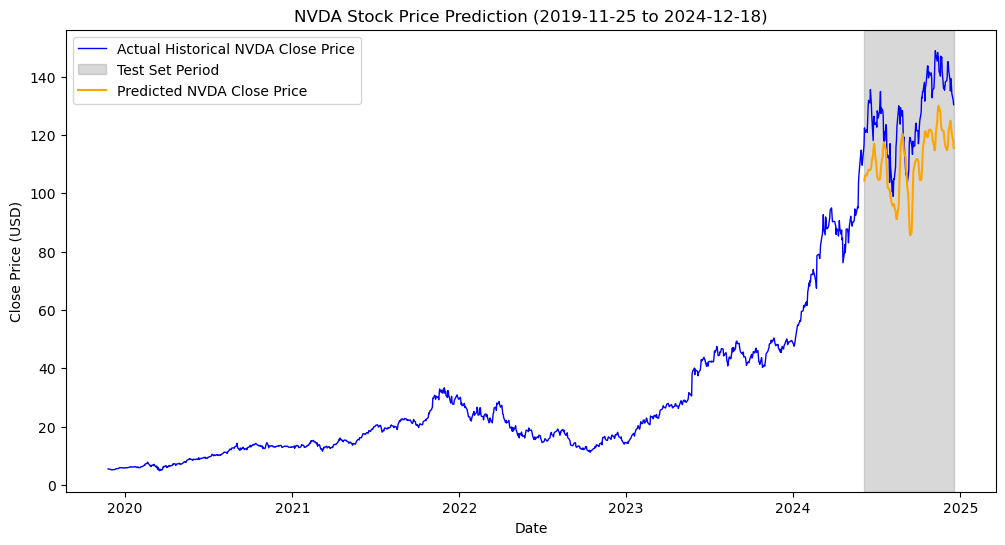

In [490]:
# Pad the test_predict and true test values to match the scaler's expected shape
test_predict_padded = np.zeros((test_predict.shape[0], scaler.n_features_in_))
test_predict_padded[:, 0] = test_predict[:, 0]  # Fill the "Close" predictions

y_test_padded = np.zeros((Y_test.shape[0], scaler.n_features_in_))
y_test_padded[:, 0] = Y_test[:, 0]  # Fill the true "Close" values

# Perform inverse transformation
test_predict_actual = scaler.inverse_transform(test_predict_padded)[:, 0]  # Extract the "Close" column
y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0]  # Extract the "Close" column

test_dates = nvda.index[-len(y_test_actual):]

plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Actual Historical NVDA Close Price')
plt.axvspan(test_dates[0], test_dates[-1], color='gray', alpha=0.3, label='Test Set Period')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

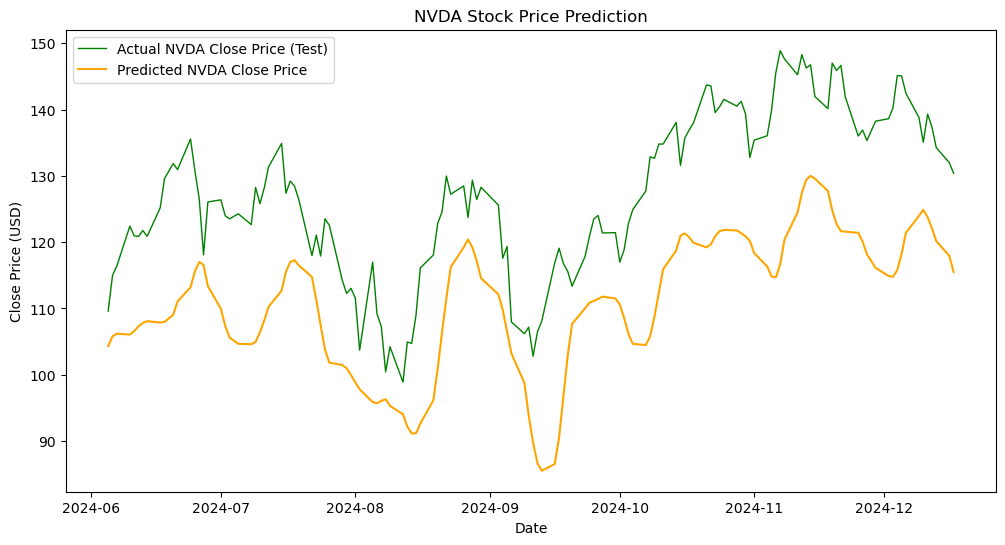

In [491]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, color='green', linewidth=1, label='Actual NVDA Close Price (Test)')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

In [492]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

print("Root Mean Squared Error: "+ str(root_mean_squared_error(y_test_actual, test_predict_actual)))
print("Mean Absolute Error: "+ str(mean_absolute_error(y_test_actual, test_predict_actual)))
print("R-Squared: "+ str(r2_score(y_test_actual, test_predict_actual)))
print("Mean Absolute Percentage Error: " + str(mean_absolute_percentage_error(y_test_actual, test_predict_actual)))

Root Mean Squared Error: 17.373741452452627
Mean Absolute Error: 16.190074940883246
R-Squared: -1.0496201852319835
Mean Absolute Percentage Error: 0.1259086607171969
